# Projeto Final de Machine Learning

<strong>Membros:</strong>
- João Laet
- Nicolas Cho
- Roger Pina

<strong>Professor:</strong>
- Fábio Ayres

<strong>Github:</strong>
- https://github.com/NicolasCho/projeto_ML

# Imports

In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import os
from sklearn.metrics import (mean_squared_error,
                             confusion_matrix,  # ConfusionMatrixDisplay,
                             roc_curve, roc_auc_score)
from sklearn import tree
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from plotnine import *
#from keras import tensorflow

---

# Data Exploration

## Data Section 1 - The basics

In [2]:
#os.chdir("data/NCAA/")

In [3]:
df_teams = pd.read_csv("Teams.csv")
seasons = pd.read_csv("Seasons.csv")
NCAATourneySeeds = pd.read_csv("NCAATourneySeeds.csv")
RegularSeasonCompactResults = pd.read_csv("RegularSeasonCompactResults.csv")
NCAATourneyCompactResults = pd.read_csv("NCAATourneyCompactResults.csv")
SampleSubmissionStage1 = pd.read_csv("SampleSubmissionStage1.csv")

### Teams

In [4]:
df_teams

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018
...,...,...,...,...
359,1460,Wright St,1988,2018
360,1461,Wyoming,1985,2018
361,1462,Xavier,1985,2018
362,1463,Yale,1985,2018


### SeasonsEloRating

In [5]:
seasons

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast
5,1990,10/30/1989,East,Midwest,Southeast,West
6,1991,10/29/1990,East,Southeast,Midwest,West
7,1992,11/4/1991,East,West,Midwest,Southeast
8,1993,11/2/1992,East,Midwest,Southeast,West
9,1994,11/1/1993,East,Southeast,Midwest,West


### Seeds

In [6]:
NCAATourneySeeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2145,2017,Z12,1292
2146,2017,Z13,1457
2147,2017,Z14,1245
2148,2017,Z15,1297


In [7]:
NCAATourneySeeds = NCAATourneySeeds[NCAATourneySeeds['Season'] < 2014]

### RegularSeasonCompactResults

In [8]:
RegularSeasonCompactResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
150679,2017,132,1276,71,1458,56,N,0
150680,2017,132,1343,71,1463,59,N,0
150681,2017,132,1348,70,1433,63,N,0
150682,2017,132,1374,71,1153,56,N,0


In [9]:
RegularSeasonCompactResults = RegularSeasonCompactResults[RegularSeasonCompactResults['Season'] < 2014]

### NCAATourneyCompactResults

In [10]:
NCAATourneyCompactResults 

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2112,2017,146,1314,75,1246,73,N,0
2113,2017,146,1376,77,1196,70,N,0
2114,2017,152,1211,77,1376,73,N,0
2115,2017,152,1314,77,1332,76,N,0


In [11]:
NCAATourneyCompactResults = NCAATourneyCompactResults[NCAATourneyCompactResults['Season'] < 2014]

### SampleSubmissionStage1

In [12]:
SampleSubmissionStage1

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5
...,...,...
9107,2017_1455_1458,0.5
9108,2017_1455_1462,0.5
9109,2017_1457_1458,0.5
9110,2017_1457_1462,0.5


In [13]:
#pbp2010 = pd.read_csv('./mens-machine-learning-competition-2018/PlayByPlay_2010/Events_2010.csv')

---

# Feature Engineering

## Elo Rating

In [14]:
def win_probs(wTeam_elo, lTeam_elo, home_court_advantage, WLoc):
    w = math.pow(10, wTeam_elo/400)
    l = math.pow(10, lTeam_elo/400)
    a = math.pow(10, home_court_advantage/400) 
    
    if WLoc == 'H':
        denom = l + a*w
        wTeam_prob = a*w / denom
        lTeam_prob = l / denom   
        
    elif WLoc == 'A':
        denom = a*l + w
        wTeam_prob = w / denom
        lTeam_prob = a*l / denom   
        
    else:
        denom = l + w
        wTeam_prob = a / denom
        lTeam_prob = l / denom 
        
    return wTeam_prob, lTeam_prob

In [15]:
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

In [16]:
def update_elo(game, df_eloActual):
    home_court_advantage = 100
    wTeam = game['WTeamID']
    wTeam_elo = int(df_eloActual[df_eloActual['TeamID'] == wTeam][str(game['Season'])])
    wTeam_score = game['WScore']
    #print(wTeam, wTeam_elo, wTeam_score)
    
    lTeam = game['LTeamID']
    lTeam_elo = int(df_eloActual[df_eloActual['TeamID'] == lTeam][str(game['Season'])])
    lTeam_score = game['LScore']
    #print(lTeam, lTeam_elo, lTeam_score)
        
    wTeam_prob, lTeam_prob = win_probs(wTeam_elo, lTeam_elo, home_court_advantage, game['WLoc'])
    
    k = elo_k(wTeam_score - lTeam_score, wTeam_elo - lTeam_elo)
        
    updated_wTeam_elo = wTeam_elo + k * (1 - wTeam_prob) 
    updated_lTeam_elo = lTeam_elo + k * (0 - lTeam_prob)
    
    return updated_wTeam_elo, updated_lTeam_elo

<strong>1 - RegularSeason</strong>
Campeonato antes da NCAA - 150K linhas de jogos (1985 - 2017)

<strong>2 - NCAA Tourney</strong>
2K linhas de jogos (1985 - 2017)

In [17]:
# 1
df_RegularSeason = RegularSeasonCompactResults.copy() # Dataframe que será adicinado o elo rating

# 2 
df_NCAATourney = NCAATourneyCompactResults.copy() # Dataframe que será adicinado o elo rating

In [18]:
df_elo = df_teams.copy().drop(columns=['TeamName', 'FirstD1Season', 'LastD1Season'])

for season in df_NCAATourney['Season'].unique():

  if season == 1985:
    df_elo[str(season)] = 1500
  else:
    df_elo[str(season)] = list(df_elo[str(season - 1)])

  #1 - Calcular o Elo Rating na Regular Season
  for index, row in df_RegularSeason[df_RegularSeason['Season'] == season].iterrows():
    updated_wTeam_elo, updated_lTeam_elo = update_elo(row, df_elo)

    #wTeam
    idx = df_elo[df_elo['TeamID'] == row['WTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_wTeam_elo
    df_RegularSeason.loc[index, 'WElo'] = updated_wTeam_elo
    
    #lTeam
    idx = df_elo[df_elo['TeamID'] == row['LTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_lTeam_elo
    df_RegularSeason.loc[index, 'LElo'] = updated_lTeam_elo 

  #2 - Calcular o Elo Rating no NCAA
  for index, row in df_NCAATourney[df_NCAATourney['Season'] == season].iterrows():
    updated_wTeam_elo, updated_lTeam_elo = update_elo(row, df_elo)

    #wTeam
    idx = df_elo[df_elo['TeamID'] == row['WTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_wTeam_elo
    df_NCAATourney.loc[index, 'WElo'] = updated_wTeam_elo
    
    #lTeam
    idx = df_elo[df_elo['TeamID'] == row['LTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_lTeam_elo
    df_NCAATourney.loc[index, 'LElo'] = updated_lTeam_elo 

## Tabela final para modelo

In [54]:
df_RegularSeason['Tourney'] = 'RS'
df_NCAATourney['Tourney'] = 'NCAA'

In [55]:
AllGames = pd.concat([df_RegularSeason ,df_NCAATourney])
AllGames['TeamA'] = AllGames[["WTeamID", "LTeamID"]].min(axis=1)
AllGames['TeamB'] = AllGames[["WTeamID", "LTeamID"]].max(axis=1)
AllGames['Mandante'] = np.where(AllGames['WLoc'] == "H", AllGames['WTeamID'],
                           np.where(AllGames['WLoc'] == "A", AllGames['LTeamID'], "0"))
AllGames['TeamAWins'] = np.where(AllGames['WTeamID'] == AllGames['TeamA'], True, False)
AllGames['EloA'] = np.where(AllGames['TeamA'] == AllGames['WTeamID'], AllGames['WElo'], AllGames['LElo'])
AllGames['EloB'] = np.where(AllGames['TeamB'] == AllGames['LTeamID'], AllGames['LElo'], AllGames['WElo'])
AllGames

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WElo,LElo,Tourney,TeamA,TeamB,Mandante,TeamAWins,EloA,EloB
0,1985,20,1228,81,1328,64,N,0,1529.290316,1485.352526,RS,1228,1328,0,True,1529.290316,1485.352526
1,1985,25,1106,77,1354,70,H,0,1506.056097,1493.943903,RS,1106,1354,1106,True,1506.056097,1493.943903
2,1985,25,1112,63,1223,56,H,0,1506.056097,1493.943903,RS,1112,1223,1112,True,1506.056097,1493.943903
3,1985,25,1165,70,1432,54,H,0,1510.120354,1489.879646,RS,1165,1432,1165,True,1510.120354,1489.879646
4,1985,25,1192,86,1447,74,H,0,1508.376562,1491.623438,RS,1192,1447,1192,True,1508.376562,1491.623438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,2013,146,1257,85,1181,63,N,0,2558.189264,2511.101542,NCAA,1181,1257,0,False,2511.101542,2558.189264
1845,2013,146,1276,79,1196,59,N,0,2324.451300,2442.406261,NCAA,1196,1276,0,False,2442.406261,2324.451300
1846,2013,152,1257,72,1455,68,N,0,2567.490343,2141.206810,NCAA,1257,1455,0,True,2567.490343,2141.206810
1847,2013,152,1276,61,1393,56,N,0,2339.680413,2441.395301,NCAA,1276,1393,0,True,2339.680413,2441.395301


In [56]:
#Cria csv ta tabela acima
#AllGames.to_csv("games_with_elo.csv", index = False)

In [57]:
AllGames = pd.read_csv("games_with_elo.csv")

In [58]:
AllGames

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WElo,LElo,Tourney,TeamA,TeamB,Mandante,TeamAWins,EloA,EloB
0,1985,20,1228,81,1328,64,N,0,1529.290316,1485.352526,RS,1228,1328,0,True,1529.290316,1485.352526
1,1985,25,1106,77,1354,70,H,0,1506.056097,1493.943903,RS,1106,1354,1106,True,1506.056097,1493.943903
2,1985,25,1112,63,1223,56,H,0,1506.056097,1493.943903,RS,1112,1223,1112,True,1506.056097,1493.943903
3,1985,25,1165,70,1432,54,H,0,1510.120354,1489.879646,RS,1165,1432,1165,True,1510.120354,1489.879646
4,1985,25,1192,86,1447,74,H,0,1508.376562,1491.623438,RS,1192,1447,1192,True,1508.376562,1491.623438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131048,2013,146,1257,85,1181,63,N,0,2558.189264,2511.101542,NCAA,1181,1257,0,False,2511.101542,2558.189264
131049,2013,146,1276,79,1196,59,N,0,2324.451300,2442.406261,NCAA,1196,1276,0,False,2442.406261,2324.451300
131050,2013,152,1257,72,1455,68,N,0,2567.490343,2141.206810,NCAA,1257,1455,0,True,2567.490343,2141.206810
131051,2013,152,1276,61,1393,56,N,0,2339.680413,2441.395301,NCAA,1276,1393,0,True,2339.680413,2441.395301


In [59]:
df = pd.DataFrame()
df['Season'] = AllGames['Season']
df['TeamA'] = AllGames['TeamA']
df['TeamB'] = AllGames['TeamB']
df['Mandante'] = AllGames['Mandante']
df['EloA'] = AllGames['EloA']
df['EloB'] = AllGames['EloB']
df['TeamAWins'] = AllGames['TeamAWins']
df

,Season,TeamA,TeamB,Mandante,EloA,EloB,TeamAWins
0,1985,1228,1328,0,1529.290316,1485.352526,True
1,1985,1106,1354,1106,1506.056097,1493.943903,True
2,1985,1112,1223,1112,1506.056097,1493.943903,True
3,1985,1165,1432,1165,1510.120354,1489.879646,True
4,1985,1192,1447,1192,1508.376562,1491.623438,True
...,...,...,...,...,...,...,...
131048,2013,1181,1257,0,2511.101542,2558.189264,False
131049,2013,1196,1276,0,2442.406261,2324.451300,False
131050,2013,1257,1455,0,2567.490343,2141.206810,True
131051,2013,1276,1393,0,2339.680413,2441.395301,True


---

# Visualização

In [25]:
from matplotlib import pyplot as plt

In [26]:
visualizacao = df.loc[df['TeamAWins'] == True].groupby(['TeamA','TeamB'])['TeamAWins'].count() / df.groupby(['TeamA','TeamB'])['TeamAWins'].count()
visualizacao = visualizacao.reset_index()
visualizacao = visualizacao.fillna(0)
visualizacao

,TeamA,TeamB,TeamAWins
0,1102,1108,1.000000
1,1102,1109,0.833333
2,1102,1115,1.000000
3,1102,1117,1.000000
4,1102,1119,0.750000
...,...,...,...
22616,1458,1462,0.333333
22617,1459,1462,0.500000
22618,1460,1462,0.400000
22619,1460,1464,0.825000


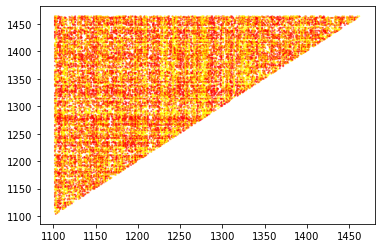

In [27]:
plt.scatter(visualizacao["TeamA"], visualizacao["TeamB"], c= visualizacao["TeamAWins"], cmap=plt.cm.autumn, alpha=0.5, s = 1)
plt.show()

Removendo pontos "seguros" (com taxa de vitória ou derrota altas)

In [28]:
visualizacao_incertos = visualizacao.loc[(visualizacao.TeamAWins > 0.4) & (visualizacao.TeamAWins < 0.6)]
visualizacao_incertos

,TeamA,TeamB,TeamAWins
7,1102,1125,0.500000
12,1102,1142,0.500000
13,1102,1143,0.500000
14,1102,1148,0.500000
17,1102,1154,0.500000
...,...,...,...
22596,1453,1460,0.500000
22601,1454,1460,0.522727
22607,1455,1462,0.500000
22609,1456,1459,0.500000


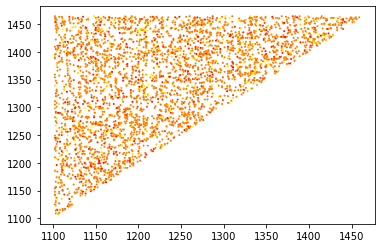

In [29]:
plt.scatter(visualizacao_incertos["TeamA"], visualizacao_incertos["TeamB"], c= visualizacao_incertos["TeamAWins"], cmap=plt.cm.autumn, alpha=1, s = 1)
plt.show()

---

# Previsão utilizando rede e Cadeia de Markov

### Criando a rede

In [30]:
import networkx as nx

G = nx.from_pandas_edgelist(visualizacao, source='TeamA', target='TeamB',
                            edge_attr='TeamAWins') 

In [31]:
visualizacao_copy = visualizacao.copy()
teams = pd.unique(visualizacao_copy[['TeamA', 'TeamB']].values.ravel('K'))
n = len(teams)
n

360

In [32]:
len(df_teams)

364

4 times não apareceram em nenhuma partida até 2014

### Matriz de transição

In [33]:
matrix = np.zeros((n,n))

In [34]:
trans_matrix = pd.DataFrame(matrix, columns = teams, index=teams)

In [35]:
trans_matrix

,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,...,1455,1456,1457,1458,1459,1460,1462,1461,1463,1464
1102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#Todos os caminhos minimos possiveis entre possibilidades de jogos
erros = 0
i = 0
for team in teams[:]:
    for opponent in teams[i+1:]:
        try:
            probability = 1
            path = nx.shortest_path(G, source=team, target=opponent)
            for source, target in zip(path, path[1:]):
                prob = G[source][target]["TeamAWins"]
                if source < target:
                    probability *= prob
                else:
                    probability *= (1 - prob)
            trans_matrix.loc[trans_matrix.index == path[0], path[-1]] = prob
        except:
            erros += 1 
    i += 1
print(erros)

0


In [37]:
trans_matrix

,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,...,1455,1456,1457,1458,1459,1460,1462,1461,1463,1464
1102,0.0,0.5,1.0,0.586207,0.553846,1.000000,1.000000,0.833333,0.827586,0.5,...,0.00,0.00000,0.0,0.0,0.666667,0.50,0.00,0.301587,1.0,0.500000
1103,0.0,0.0,0.0,1.000000,1.000000,0.480000,0.111111,0.500000,1.000000,1.0,...,0.75,0.00000,0.5,0.5,1.000000,0.75,0.00,0.500000,1.0,0.814815
1104,0.0,0.0,0.0,1.000000,1.000000,0.307692,0.586207,0.500000,1.000000,1.0,...,0.75,0.00000,1.0,0.5,1.000000,0.75,0.75,0.500000,1.0,1.000000
1105,0.0,0.0,0.0,0.000000,0.264706,1.000000,0.586207,0.000000,1.000000,1.0,...,0.00,1.00000,1.0,0.5,1.000000,0.00,0.75,0.000000,1.0,1.000000
1106,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.553846,0.000000,1.000000,1.0,...,0.75,0.74359,1.0,0.5,1.000000,0.00,0.75,0.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.40,0.301587,1.0,0.825000
1462,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.00,0.301587,1.0,1.000000
1461,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.00,0.000000,1.0,0.500000
1463,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.00,0.000000,0.0,0.500000


In [38]:
# widths = np.array([w for *_, w in G.edges.data('TeamAWins')])

# pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibi

# # nodes
# nx.draw_networkx_nodes(G, pos)

# # edges
# nx.draw_networkx_edges(G, pos, width=widths)  

# # labels
# nx.draw_networkx_labels(G, pos, font_family="sans-serif")

# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.tight_layout()

---

# Aplicando Modelos

In [39]:
df1 = df.drop(columns=['Mandante', "Season"])
df1[['TeamA','TeamB']] = df[['TeamA','TeamB']].astype(str)

In [40]:
from sklearn.linear_model import LogisticRegression
RANDOM_SEED = 42
train_set, test_set = train_test_split(
    df1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

X_train = train_set.drop(columns=['TeamAWins'])
y_train = train_set['TeamAWins']

X_test = test_set.drop(columns=['TeamAWins'])
y_test = test_set['TeamAWins']

## Logistic regression

In [41]:
rl = LogisticRegression()
rl.fit(X_train, y_train)
y_pred_rl = rl.predict(X_test)

In [42]:
CM_RL = confusion_matrix(y_test, y_pred_rl)
print(CM_RL, "\n")

accuracy = (CM_RL[0, 0] + CM_RL[1, 1]) / CM_RL.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RL[1, 1] / (CM_RL[1, 0] + CM_RL[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RL[0, 1] / (CM_RL[0, 0] + CM_RL[0, 1])
print(f"Specificity: {specificity:.4f}")

[[9804 3538]
 [3517 9352]] 

Accuracy:    0.7308
Sensitivity: 0.7267
Specificity: 0.2652


## Random Forest

In [43]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [44]:
CM_RF = confusion_matrix(y_test, y_pred_rf)
print(CM_RF, "\n")

accuracy = (CM_RF[0, 0] + CM_RF[1, 1]) / CM_RF.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RF[1, 1] / (CM_RF[1, 0] + CM_RF[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RF[0, 1] / (CM_RF[0, 0] + CM_RF[0, 1])
print(f"Specificity: {specificity:.4f}")

[[9496 3846]
 [3932 8937]] 

Accuracy:    0.7033
Sensitivity: 0.6945
Specificity: 0.2883


## Decision Tree

In [45]:
dt = tree.DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [46]:
CM_DT = confusion_matrix(y_test, y_pred_dt)
print(CM_DT, "\n")

accuracy = (CM_DT[0, 0] + CM_DT[1, 1]) / CM_DT.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_DT[1, 1] / (CM_DT[1, 0] + CM_DT[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_DT[0, 1] / (CM_DT[0, 0] + CM_DT[0, 1])
print(f"Specificity: {specificity:.4f}")

[[8444 4898]
 [4682 8187]] 

Accuracy:    0.6345
Sensitivity: 0.6362
Specificity: 0.3671


# Modelos com dados de mandante

In [62]:
df2 = df.drop(columns=["Season"])
df2[['TeamA','TeamB',"Mandante"]] = df[['TeamA','TeamB',"Mandante"]].astype(str)
df2

,TeamA,TeamB,Mandante,EloA,EloB,TeamAWins
0,1228,1328,0,1529.290316,1485.352526,True
1,1106,1354,1106,1506.056097,1493.943903,True
2,1112,1223,1112,1506.056097,1493.943903,True
3,1165,1432,1165,1510.120354,1489.879646,True
4,1192,1447,1192,1508.376562,1491.623438,True
...,...,...,...,...,...,...
131048,1181,1257,0,2511.101542,2558.189264,False
131049,1196,1276,0,2442.406261,2324.451300,False
131050,1257,1455,0,2567.490343,2141.206810,True
131051,1276,1393,0,2339.680413,2441.395301,True


In [63]:
train_setM, test_setM = train_test_split(
    df2,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

X_trainM = train_setM.drop(columns=['TeamAWins'])
y_trainM = train_setM['TeamAWins']

X_testM = test_setM.drop(columns=['TeamAWins'])
y_testM = test_setM['TeamAWins']

## Regressão Logística

In [64]:
rlM = LogisticRegression()
rlM.fit(X_trainM, y_trainM)
y_pred_rlM = rlM.predict(X_testM)

CM_RLM = confusion_matrix(y_testM, y_pred_rlM)
print(CM_RLM, "\n")

accuracy = (CM_RLM[0, 0] + CM_RLM[1, 1]) / CM_RLM.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RLM[1, 1] / (CM_RLM[1, 0] + CM_RLM[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RLM[0, 1] / (CM_RLM[0, 0] + CM_RLM[0, 1])
print(f"Specificity: {specificity:.4f}")

[[9805 3537]
 [3510 9359]] 

Accuracy:    0.7311
Sensitivity: 0.7273
Specificity: 0.2651


## Random Forest

In [65]:
rfM = RandomForestClassifier(random_state = 42)
rfM.fit(X_trainM, y_trainM)
y_pred_rfM = rfM.predict(X_testM)

CM_RFM = confusion_matrix(y_testM, y_pred_rfM)
print(CM_RFM, "\n")

accuracy = (CM_RFM[0, 0] + CM_RFM[1, 1]) / CM_RFM.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RFM[1, 1] / (CM_RFM[1, 0] + CM_RFM[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RFM[0, 1] / (CM_RFM[0, 0] + CM_RFM[0, 1])
print(f"Specificity: {specificity:.4f}")

[[9841 3501]
 [3529 9340]] 

Accuracy:    0.7318
Sensitivity: 0.7258
Specificity: 0.2624


## Decision Tree

In [66]:
dtM = tree.DecisionTreeClassifier(random_state = 42)
dtM.fit(X_trainM, y_trainM)
y_pred_dtM = dtM.predict(X_testM)

CM_DTM = confusion_matrix(y_testM, y_pred_dtM)
print(CM_DTM, "\n")

accuracy = (CM_DTM[0, 0] + CM_DTM[1, 1]) / CM_DTM.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_DTM[1, 1] / (CM_DTM[1, 0] + CM_DTM[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_DTM[0, 1] / (CM_DTM[0, 0] + CM_DTM[0, 1])
print(f"Specificity: {specificity:.4f}")

[[8844 4498]
 [4447 8422]] 

Accuracy:    0.6587
Sensitivity: 0.6544
Specificity: 0.3371


# Comparação dos Modelos

In [67]:
y_pred_prob_rl = rl.predict_proba(X_test)
y_pred_prob_rl = y_pred_prob_rl[:, 1]

y_pred_prob_rf = rf.predict_proba(X_test)
y_pred_prob_rf = y_pred_prob_rf[:, 1]

y_pred_prob_dt = dt.predict_proba(X_test)
y_pred_prob_dt = y_pred_prob_dt[:, 1]


y_pred_prob_rlM = rlM.predict_proba(X_testM)
y_pred_prob_rlM = y_pred_prob_rlM[:, 1]

y_pred_prob_rfM = rfM.predict_proba(X_testM)
y_pred_prob_rfM = y_pred_prob_rfM[:, 1]

y_pred_prob_dtM = dtM.predict_proba(X_testM)
y_pred_prob_dtM = y_pred_prob_dtM[:, 1]

In [68]:
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_test, y_pred_prob_rl)
print(f"AUC score regressão logística:    {roc_auc_score(y_test, y_pred_prob_rl):.4f}")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
print(f"AUC score random forest:    {roc_auc_score(y_test, y_pred_prob_rf):.4f}")

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_prob_dt)
print(f"AUC score decision tree:    {roc_auc_score(y_test, y_pred_prob_dt):.4f}")


fpr_rlM, tpr_rlM, thresholds_rlM = roc_curve(y_testM, y_pred_prob_rlM)
print(f"AUC score regressão logística com mandante:    {roc_auc_score(y_testM, y_pred_prob_rlM):.4f}")

fpr_rfM, tpr_rfM, thresholds_rfM = roc_curve(y_testM, y_pred_prob_rfM)
print(f"AUC score random forest com mandante:    {roc_auc_score(y_testM, y_pred_prob_rfM):.4f}")

fpr_dtM, tpr_dtM, thresholds_dtM = roc_curve(y_testM, y_pred_prob_dtM)
print(f"AUC score decision tree com mandante:    {roc_auc_score(y_testM, y_pred_prob_dtM):.4f}")

AUC score regressão logística:    0.8062
AUC score random forest:    0.7779
AUC score decision tree:    0.6345
AUC score regressão logística com mandante:    0.8069
AUC score random forest com mandante:    0.8119
AUC score decision tree com mandante:    0.6587


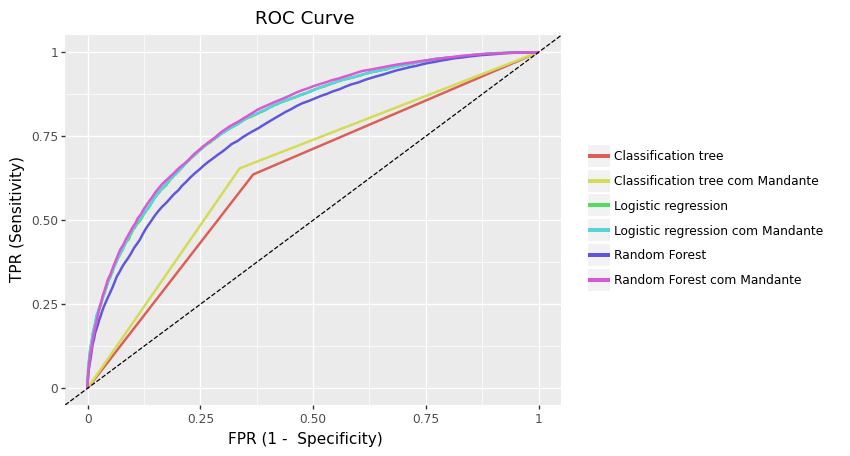

<ggplot: (85952916071)>

In [69]:
(pd.concat([pd.DataFrame(dict(fpr = fpr_rl, tpr = tpr_rl, model = "Logistic regression")),
            pd.DataFrame(dict(fpr = fpr_dt, tpr = tpr_dt, model = "Classification tree")), 
            pd.DataFrame(dict(fpr = fpr_rf,   tpr = tpr_rf,   model = "Random Forest")),
            pd.DataFrame(dict(fpr = fpr_rlM, tpr = tpr_rlM, model = "Logistic regression com Mandante")),
            pd.DataFrame(dict(fpr = fpr_dtM, tpr = tpr_dtM, model = "Classification tree com Mandante")),
            pd.DataFrame(dict(fpr = fpr_rfM,   tpr = tpr_rfM,   model = "Random Forest com Mandante"))])
   .pipe(lambda _: ggplot(_, aes(x = "fpr", y = "tpr", color = "model")) +
                       geom_line(size = 1) + 
                       geom_abline(linetype = "dashed") +
                       labs(x = "FPR (1 -  Specificity)", y = "TPR (Sensitivity)",
                            title = "ROC Curve") +
                       theme(legend_title = element_blank())))

---

# Prevendo os jogos de 2014

In [ ]:
SampleSubmissionStage1_copy = SampleSubmissionStage1.copy()

In [ ]:
SampleSubmissionStage1_copy[['Season', 'TeamA', 'TeamB']] = SampleSubmissionStage1_copy['ID'].str.split(pat = '_', expand = True)
SampleSubmissionStage1_copy

In [ ]:
season_2014 = SampleSubmissionStage1_copy.loc[SampleSubmissionStage1_copy['Season']=="2014"]
season_2014

### Utilizando a matriz de transição

In [ ]:
matrix_predictions = season_2014.copy()

In [ ]:
for index, row in matrix_predictions.iterrows():
    matrix_predictions.loc[(matrix_predictions['TeamA'] == row['TeamA'])&(matrix_predictions['TeamB'] == row['TeamB']), 'Pred'] = trans_matrix.loc[trans_matrix.index == int(row['TeamA']), int(row['TeamB'])].values[0]

In [ ]:
matrix_predictions

Verificar resultados!

### Utilizando o modelo de regressão logística

Precisa dos elos dos times em 2014 para passar pro modelo de regressão